In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import get_window
import glob
import time

def plot_scatter_func(x, y, label, title, xlab, ylab, x1 = None, x2 = None, y1 = None, y2 = None):

    f, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(x, y, label = label)
    ax.set_title(title, fontsize = 30)
    ax.set_xlabel(xlab, fontsize = 30)
    ax.set_ylabel(ylab, fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    ax.legend(loc = 'best', fontsize = 20)
    ax.grid(True)

    return f

def phase_func(Y):
    phases = np.angle(Y) * 180 / np.pi
    
    return phases

#dBu = 20log10(V/0.775V)

#Why the windowing? The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.

def rfft(y, cnv): #this function computes the fft of y
    window = get_window("hanning", len(y))
    y_windowed = y * window

    N = len(y)

    Y = fft.rfft(y_windowed)
    phases = phase_func(Y)
    Y_normalized = np.abs(Y) / N
    Y_dBu = 20*(np.log10(np.abs(Y_normalized)) * cnv / 0.775)
        
    return Y_dBu, phases

In [28]:
hour = '15.46'
day = '07082024'

# Method A: Phases of the average of the waveforms

### compute and plot the average of the waveforms

In [29]:
file_pattern = f"../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list_A = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_A = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values #The argument errors='coerce' specifies that any non-numeric values encountered during the conversion should be replaced with NaN (Not a Number)
        amplitudes_A = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list_A.append(amplitudes_A)

all_amplitudes_A = np.stack(amplitudes_list_A, axis = 0)
print(all_amplitudes_A)

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -7.08661400
2        -6.69291300
3        -6.29921200
4        -6.29921200
            ...     
62500    -6.69291300
62501    -6.69291300
62502    -6.69291300
62503    -6.69291300
62504    -6.69291300
Name: Channel D, Length: 62505, dtype: object
[[-7.086614  -6.692913  -6.299212  ... -6.692913  -6.692913  -6.692913 ]
 [ 0.3937007  0.3937007  0.7874015 ...  3.543307   2.755905   2.755905 ]
 [ 1.181102   1.181102   0.        ... -1.968504  -0.7874015  0.3937007]
 ...
 [ 2.362205   2.755905   3.149606  ...  2.755905   2.362205   2.755905 ]
 [-1.181102  -2.755905  -3.149606  ... -2.362205  -3.149606  -3.149606 ]
 [ 0.7874015 -1.181102  -1.968504  ... -2.362205  -2.755905  -3.149606 ]]


In [30]:
#The ADC of the Picoscope only represents discrete levels of input voltage in 8 bit resolution
conversion_factor = 0.001

avg_wf = np.mean(all_amplitudes_A, axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


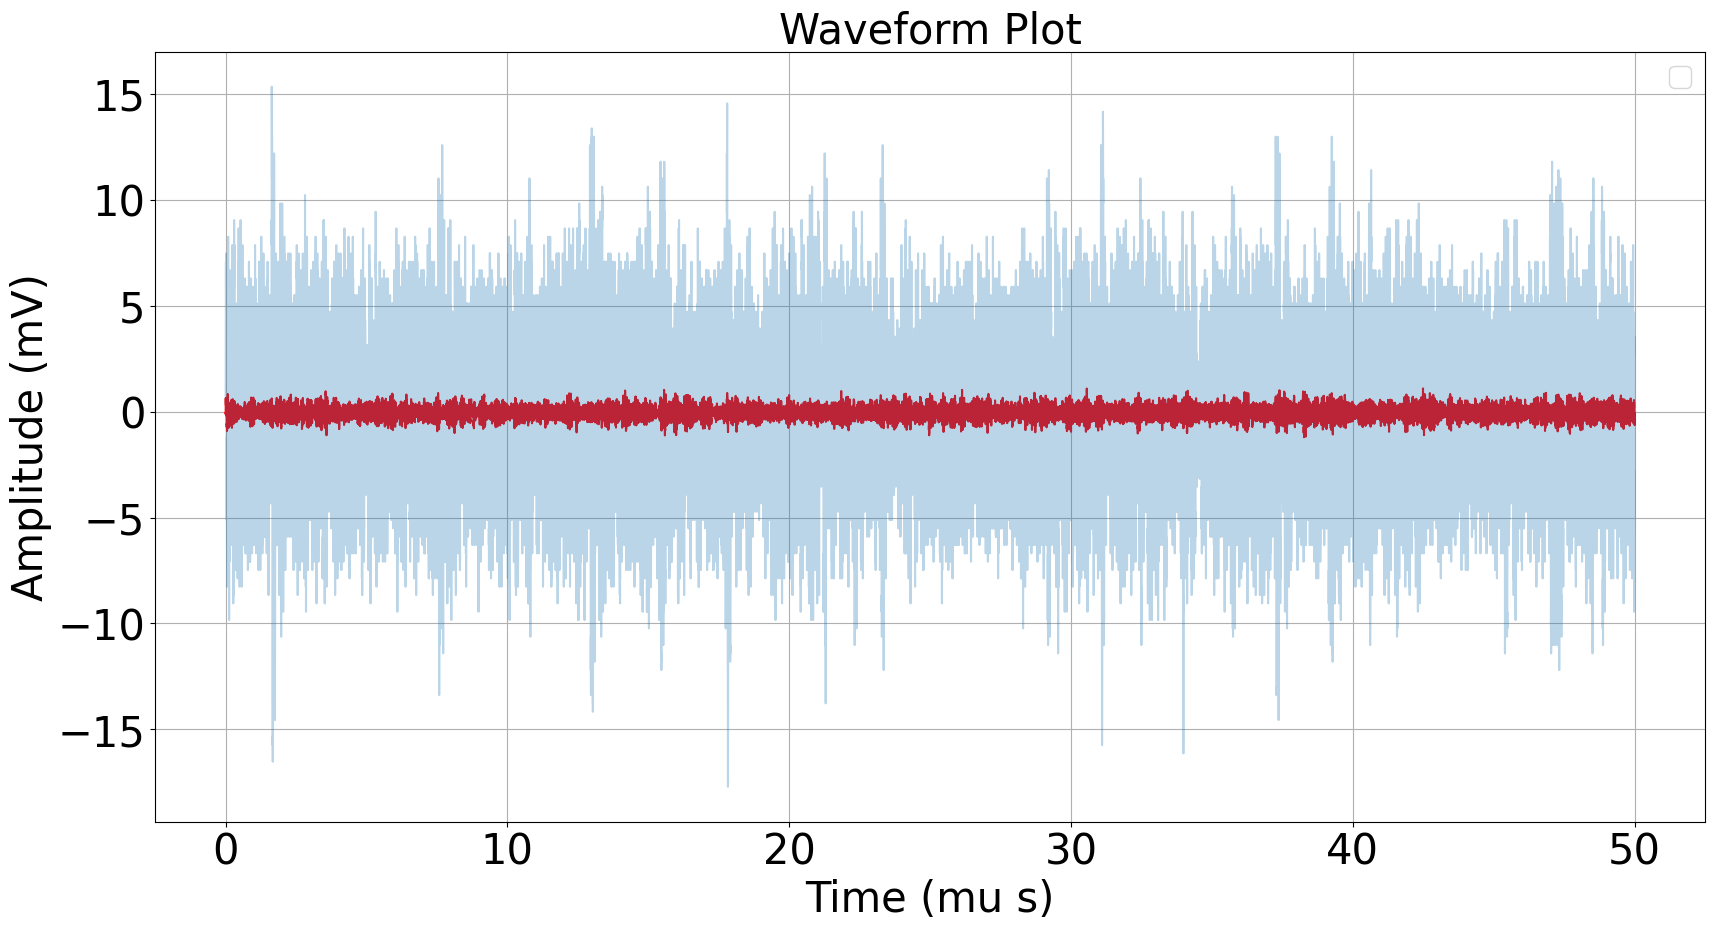

In [31]:
plt.figure(figsize=(20, 10))
#plt.errorbar(times_A, A, yerr=stds_wf, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1, label = f"{hour}_{day}")
plt.plot(times_A, avg_wf, color = 'red')

plt.plot(times_A, all_amplitudes_A[1, :], alpha = 0.3)

plt.title('Waveform Plot', fontsize = 30)
plt.xlabel('Time (mu s)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude (mV)', fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(loc = "best",  prop={'size': 20})
plt.grid(True)
plt.show()

### compute and plot the phases of the average waveform

f_s_A = [1250.01998229]
[-0.04186912 -0.05015902 -0.07284187 ... -0.07993218 -0.08124678
 -0.08149032]
[-0.05109584 -0.05919791 -0.07785928 ... -0.08072492 -0.07771869
 -0.08770732]


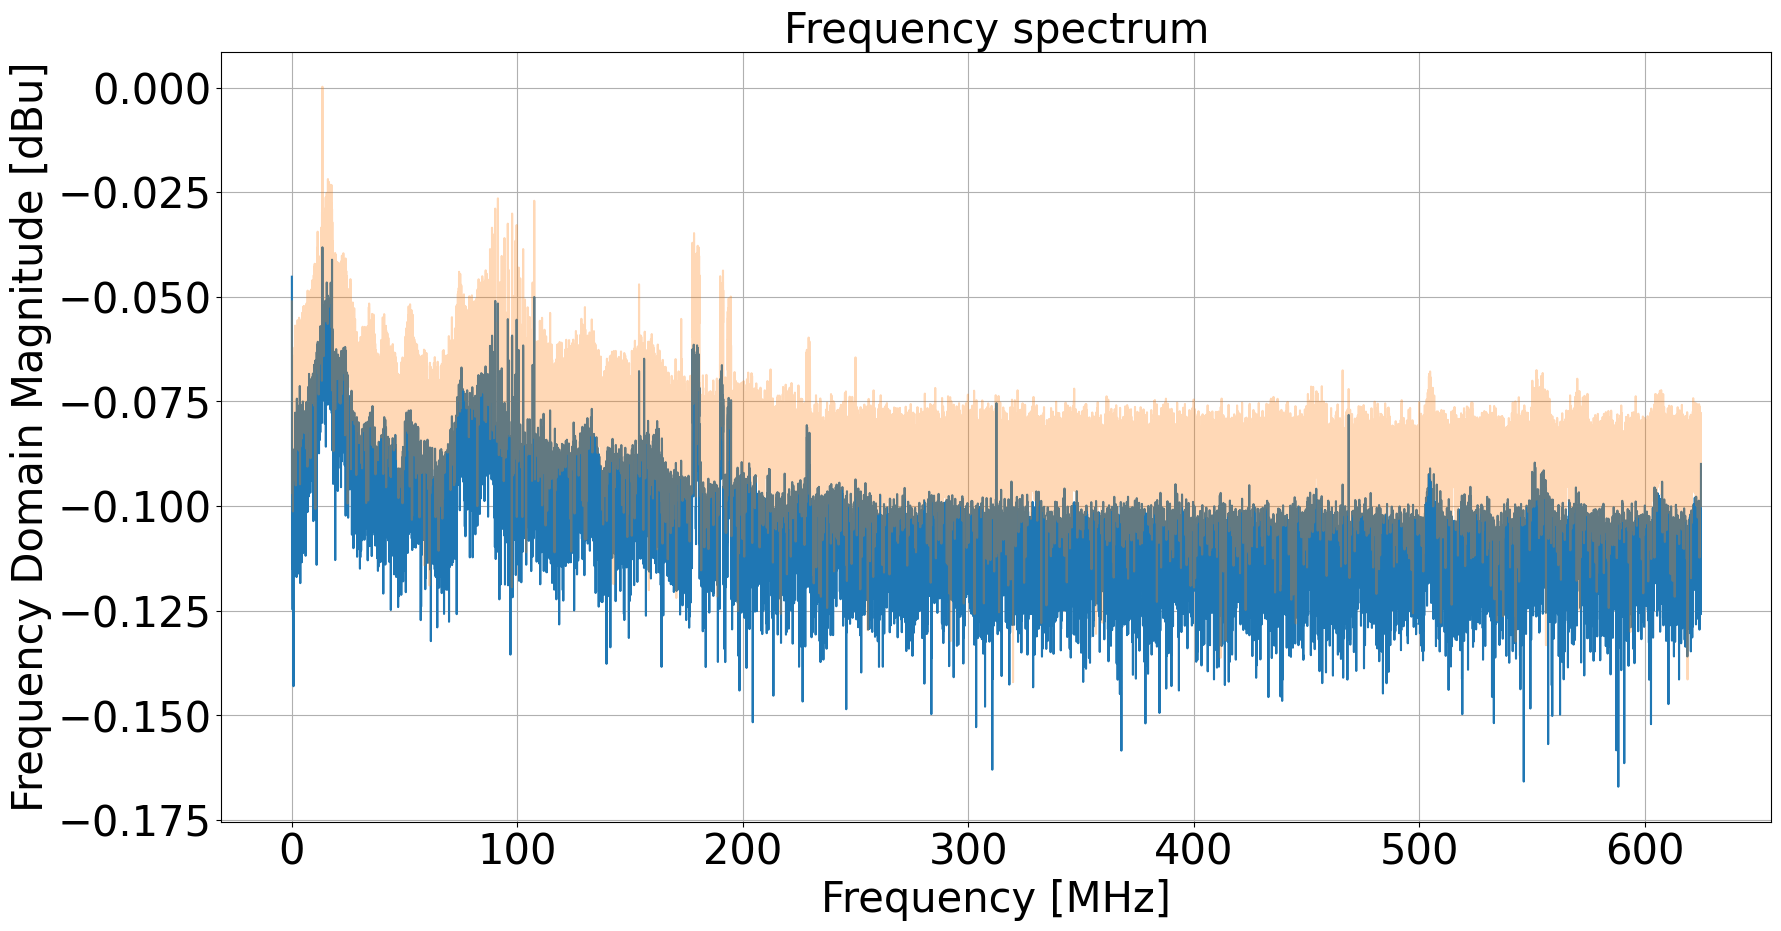

Execution time: 0.7624037265777588 seconds


In [45]:
span_A = times_A[-1:]
f_s_A = len(times_A) / span_A
print(f"f_s_A = {f_s_A}")
freqs_A = fft.rfftfreq(len(avg_wf), 1/f_s_A) #window lenght, sample spacing

#plot the fft and see how much time it takes
start_time = time.time()

Y_dBu_A, phases_A = rfft(avg_wf, conversion_factor)
Y_dBu_single_wf_A, phases_single_wf_A = rfft(all_amplitudes_A[1, :], conversion_factor)

plt.figure(figsize = (20, 10))
#plt.errorbar(freqs_A, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_A, Y_dBu_A)
plt.plot(freqs_A, Y_dBu_single_wf_A, alpha = 0.3)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [46]:
offset_blue = np.mean(Y_dBu_A[(freqs_A >= 250) & (freqs_A <= 350)])
offset_orange = np.mean(Y_dBu_single_wf_A[(freqs_A >= 250) & (freqs_A <= 350)])
print(f"offset blue: {offset_blue} - offset orange: {offset_orange} = {offset_blue - offset_orange}")
diff = offset_blue - offset_orange

offset blue: -0.11030903196032454 - offset orange: -0.08711572057955154 = -0.023193311380773005


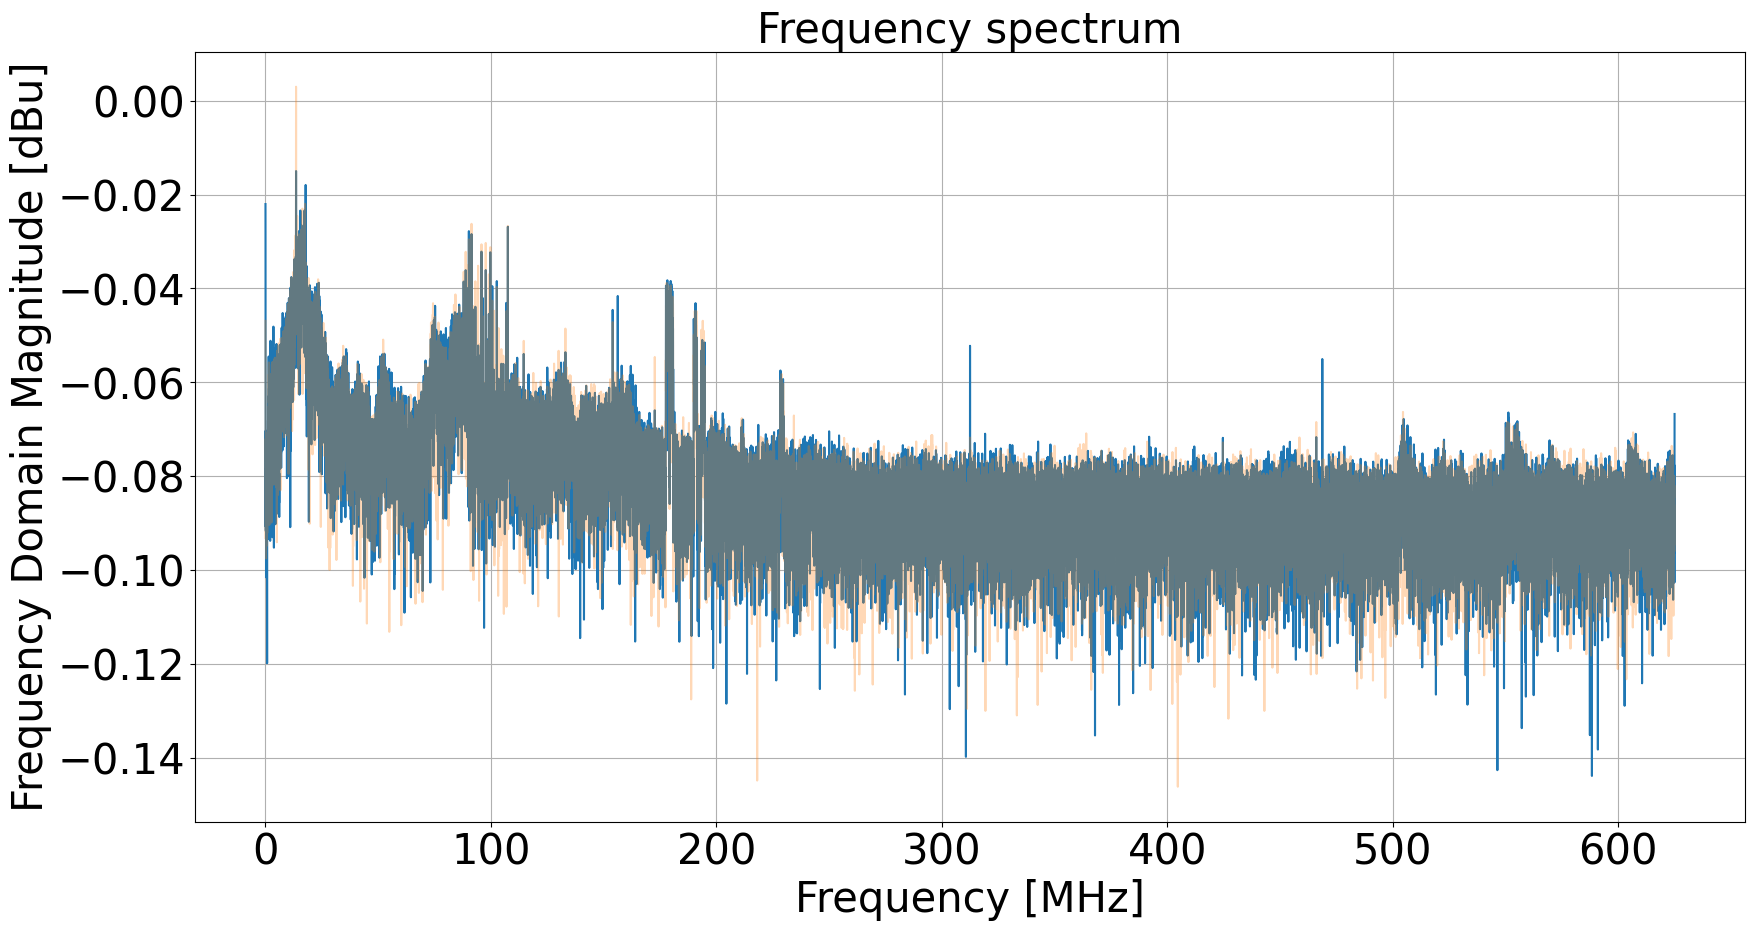

Execution time: 6.443455219268799 seconds


In [43]:
plt.figure(figsize = (20, 10))
#plt.errorbar(freqs_A, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_A, Y_dBu_A - diff)
plt.plot(freqs_A, Y_dBu_single_wf_A, alpha = 0.3)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

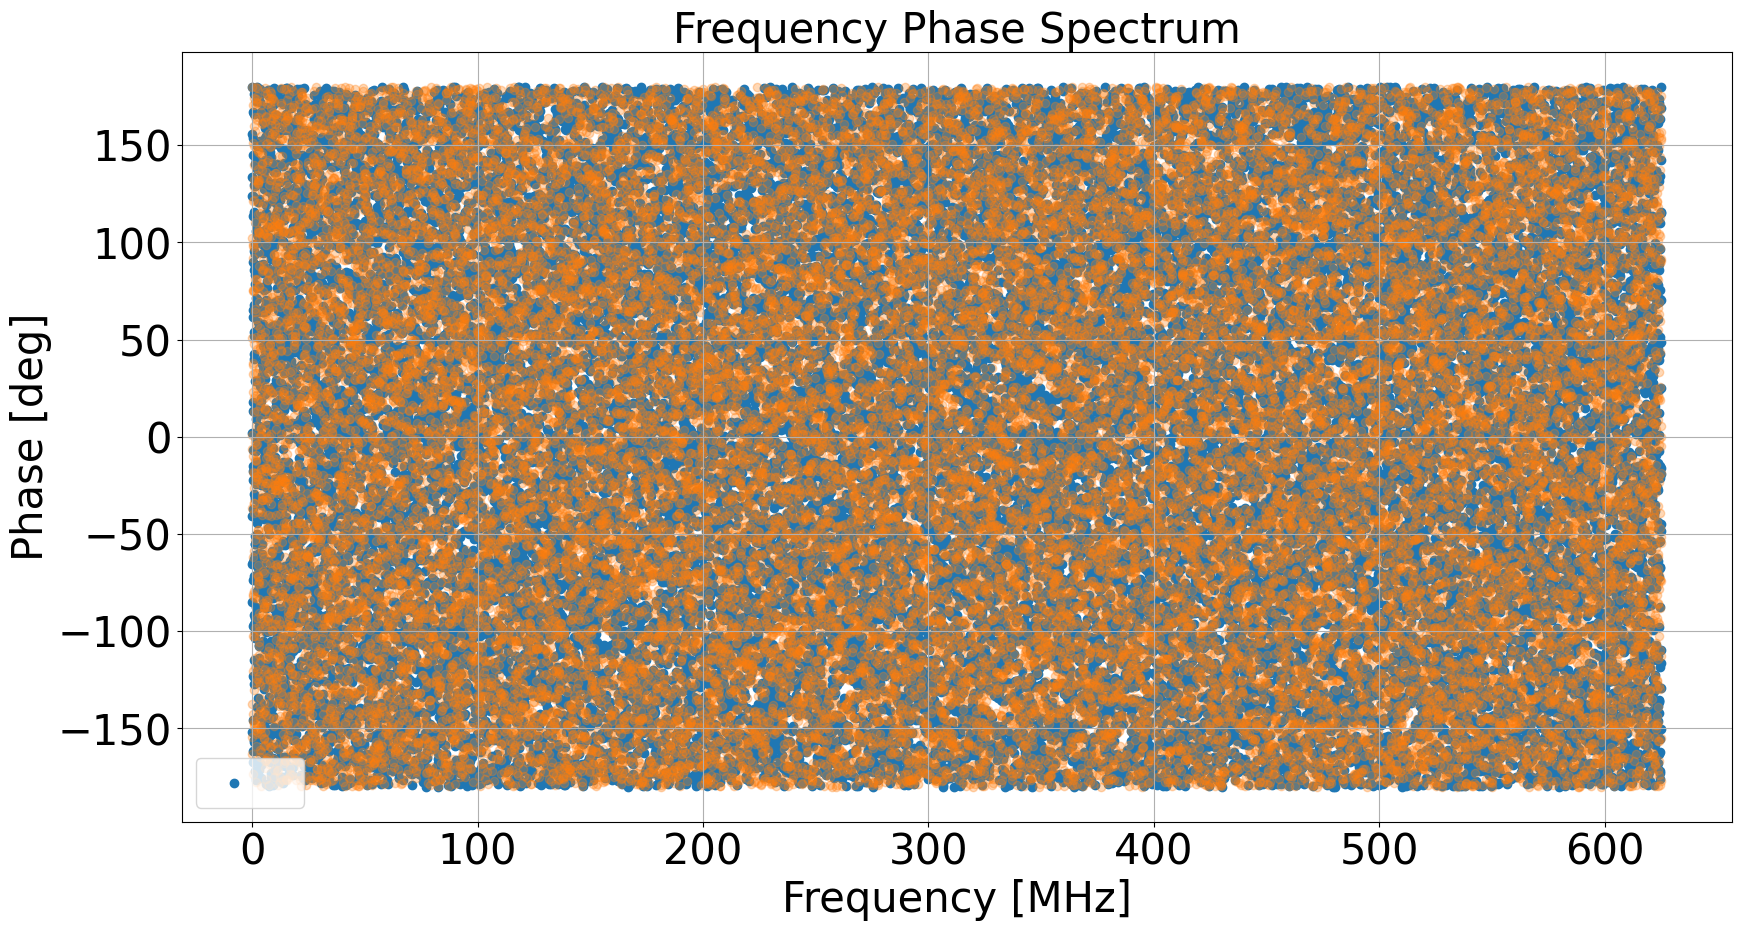

In [48]:
fig = plot_scatter_func(freqs_A, phases_A, ' ', 'Frequency Phase Spectrum', 'Frequency [MHz]', 'Phase [deg]')
plt.scatter(freqs_A, phases_single_wf_A, alpha = 0.3)

plt.show()

# Method B: Average of the phases of the ffts

In [49]:
file_pattern_wfs = f"../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_wfs = glob.glob(file_pattern_wfs)

amplitudes_list_B = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list_wfs):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_B = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes_B = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list_B.append(amplitudes_B)
            
all_amplitudes_B = np.stack(amplitudes_list_B, axis = 0)
print(all_amplitudes_B)


0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -7.08661400
2        -6.69291300
3        -6.29921200
4        -6.29921200
            ...     
62500    -6.69291300
62501    -6.69291300
62502    -6.69291300
62503    -6.69291300
62504    -6.69291300
Name: Channel D, Length: 62505, dtype: object
[[-7.086614  -6.692913  -6.299212  ... -6.692913  -6.692913  -6.692913 ]
 [ 0.3937007  0.3937007  0.7874015 ...  3.543307   2.755905   2.755905 ]
 [ 1.181102   1.181102   0.        ... -1.968504  -0.7874015  0.3937007]
 ...
 [ 2.362205   2.755905   3.149606  ...  2.755905   2.362205   2.755905 ]
 [-1.181102  -2.755905  -3.149606  ... -2.362205  -3.149606  -3.149606 ]
 [ 0.7874015 -1.181102  -1.968504  ... -2.362205  -2.755905  -3.149606 ]]


In [50]:
#The ADC of the Picoscope only represents discrete levels of input voltage in 8 bit resolution
conversion_factor = 0.001

### compute the FFTs

In [54]:
Ys_dBu_list = []
phases_list = []

for i in range(all_amplitudes_B.shape[0]):
    Y_dBu_B, phase_B = rfft(all_amplitudes_B[i, :], conversion_factor)
    Ys_dBu_list.append(Y_dBu_B)
    phases_list.append(phase_B)

Ys_dBu_B = np.stack(Ys_dBu_list, axis = 0)
phases_B = np.stack(phases_list, axis = 0)
print(f"Ys_dBu_B: {Ys_dBu_B}")
print(f"phases_B: {phases_B}")

Ys_dBu_B: [[-0.04073628 -0.04792251 -0.07685496 ... -0.10675103 -0.0868938
  -0.0809117 ]
 [-0.04186912 -0.05015902 -0.07284187 ... -0.07993218 -0.08124678
  -0.08149032]
 [-0.0477326  -0.05560758 -0.0870099  ... -0.08190591 -0.10180542
  -0.07902199]
 ...
 [-0.04103412 -0.04870034 -0.10502156 ... -0.08706143 -0.08574942
  -0.0869235 ]
 [-0.04276217 -0.05027322 -0.08813045 ... -0.08720274 -0.08468425
  -0.07995606]
 [-0.0445603  -0.05238464 -0.08476009 ... -0.08757693 -0.08362542
  -0.07878418]]
phases_B: [[ 180.            3.60881376  179.93149673 ...  100.10205211
     2.03272152  180.        ]
 [ 180.            0.52928637   -8.28369781 ...  143.94118433
  -118.25783049    0.        ]
 [ 180.            1.03586053  -62.49295138 ...  -15.66906974
   -56.27142264  180.        ]
 ...
 [ 180.            0.9334994   -99.59436607 ...   -9.73809266
    89.61672844  180.        ]
 [ 180.            3.82532852 -163.33669323 ...   -3.33081444
   -63.87364462  180.        ]
 [ 180.           -

### compute and plot the average fft and the average of their phases

In [55]:
span_B = times_B[len(times_B)-1] 
f_s_avg_fft = len(times_B) / span_B
print(f"f_s_avg_fft = {f_s_avg_fft}")
freqs_B = fft.rfftfreq(all_amplitudes_B.shape[1], 1/f_s_avg_fft) #window lenght, sample spacing

avg_fft_dBu_B = np.mean(Ys_dBu_B, axis = 0)
avg_phases_B = np.mean(phases_B, axis = 0)
print(f"avg_fft_dBu_B: {avg_fft_dBu_B}")
print(f"avg_phases_B: {avg_phases_B}")


f_s_avg_fft = 1250.0199822905822
avg_fft_dBu_B: [-0.04600055 -0.0536514  -0.08192443 ... -0.0870521  -0.08696198
 -0.08707672]
avg_phases_B: [180.           2.6761136  -23.00159453 ...  10.16720125  -9.5323834
 137.8125    ]


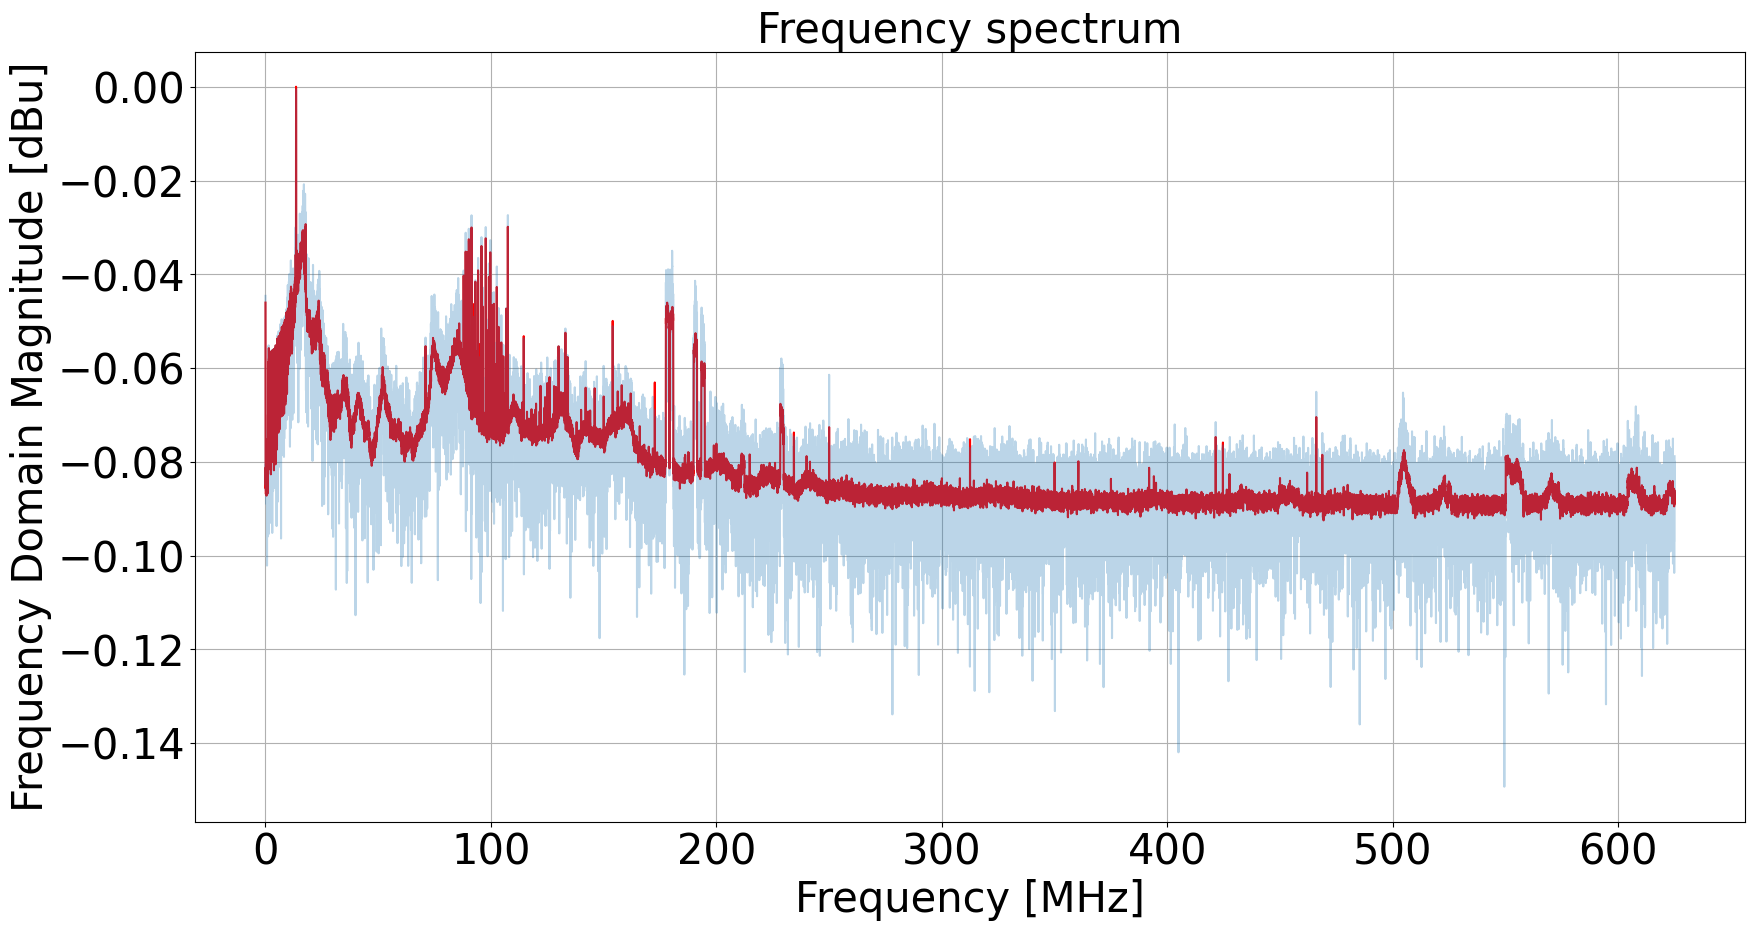

In [57]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_B, avg_fft_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_B, avg_fft_dBu_B, color = 'red')
plt.plot(freqs_B, Y_dBu_B, alpha = 0.3)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()
plt.show()


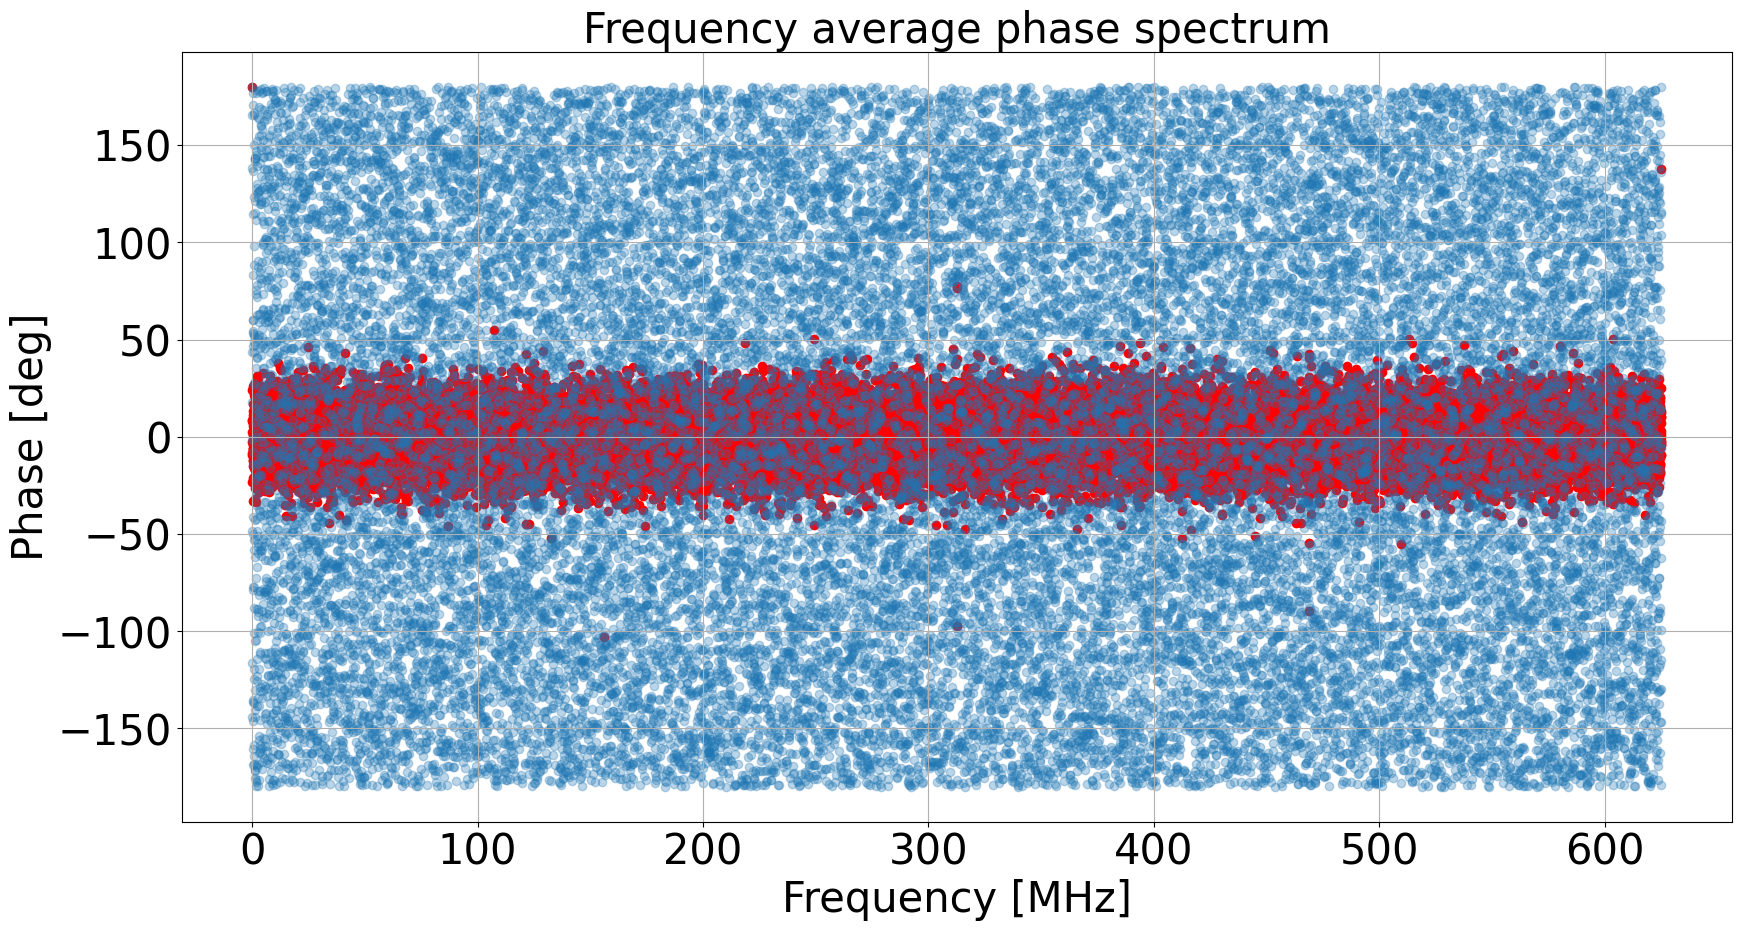

In [58]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_B, phases_avg, yerr = phases_err_avg, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_B, avg_phases_B, color = 'red')
plt.scatter(freqs_B, phase_B, alpha = 0.3)
plt.title('Frequency average phase spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phase [deg]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()


# Comparison between the two methods

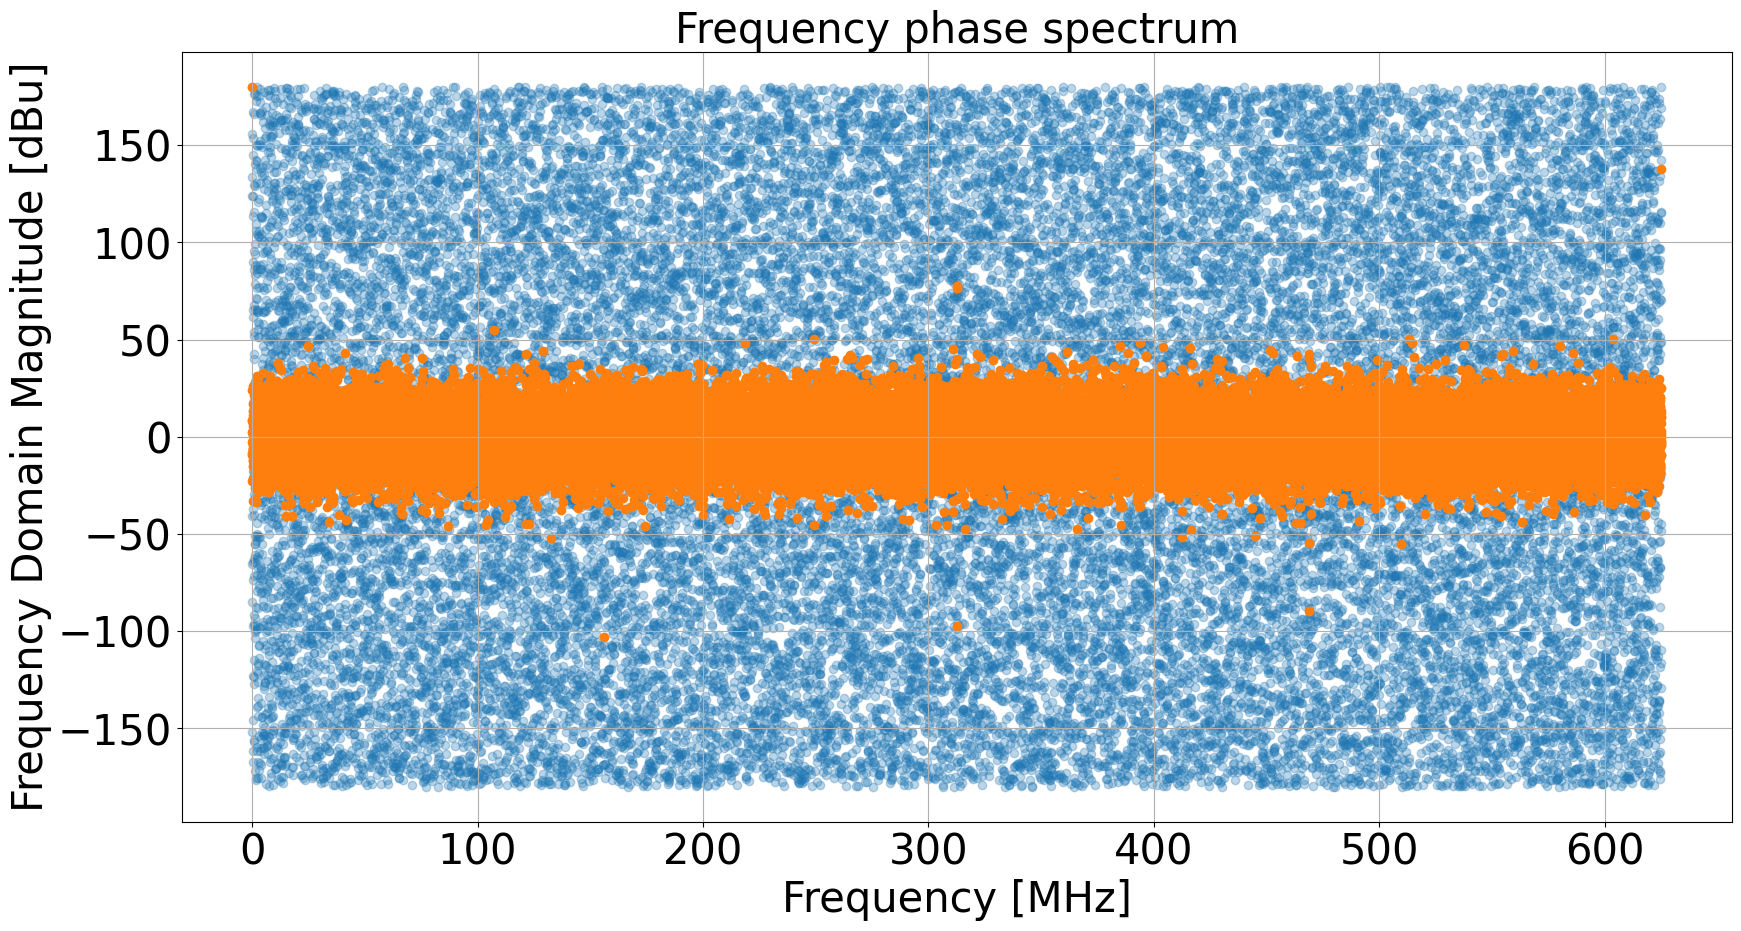

In [60]:
plt.figure(figsize=(20, 10))

#plt.errorbar(freqs, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_A, phases_A, alpha = 0.3)
plt.title('Frequency phase spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#---------------------------------------------------------------
#plt.errorbar(freqs, magnitudes_avg, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_B, avg_phases_B)


#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()